In [1]:
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.6 MB/s eta 0:00:00


# Imports and configs

In [2]:
from detectron2.data import detection_utils as utils, build_detection_train_loader, DatasetCatalog, MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultTrainer, hooks
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2 import model_zoo
from sklearn.model_selection import StratifiedGroupKFold
from tqdm.notebook import tqdm
import detectron2.data.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import random
import torch
import json
import copy
import cv2
import os

setup_logger()
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    dataset_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
    train_image_path = os.path.join(dataset_path, "train")
    train_label_path = os.path.join(dataset_path, "train_labels.csv")
    sample_sub_path = os.path.join(dataset_path, "sample_submission.csv")

    seed = 42
    n_folds = 5
    current_fold = 0
    
    model_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
    output_dir = model_name.split("/")[1].split(".")[0] + "_fold_" + str(current_fold)
    
    box_size = 64
    checkpoint_period = 500
    eval_period = 500
    warmup_iters = 1000
    max_iter = 6500
    learning_rate = 0.001
    batch_size = 8
    threshold = 0.4

In [4]:
os.makedirs(CFG.output_dir, exist_ok=True)

In [5]:
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed_all(CFG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data preprocessing

In [6]:
def create_dataset(tomogram_ids, labels):
    dataset_dicts = []
    
    for tomo_id in tqdm(tomogram_ids):
        tomo_motors = labels[labels['tomo_id'] == tomo_id]
        
        if len(tomo_motors) == 0:
            continue
            
        array_shape = [
            tomo_motors['Array shape (axis 0)'].iloc[0],
            tomo_motors['Array shape (axis 1)'].iloc[0],
            tomo_motors['Array shape (axis 2)'].iloc[0]
        ]
        
        tomo_path = os.path.join(CFG.train_image_path, str(tomo_id))
        
        for _, motor in tomo_motors.iterrows():
            z_pos = int(motor['Motor axis 0'])
            y_pos = int(motor['Motor axis 1'])
            x_pos = int(motor['Motor axis 2'])
            
            box_size = CFG.box_size
            x1 = max(0, x_pos - box_size//2)
            y1 = max(0, y_pos - box_size//2)
            x2 = min(array_shape[2], x_pos + box_size//2)
            y2 = min(array_shape[1], y_pos + box_size//2)
            
            slice_path = os.path.join(tomo_path, f"slice_{z_pos:04d}.jpg")
            if not os.path.exists(slice_path):
                continue

            img = cv2.imread(slice_path, cv2.IMREAD_GRAYSCALE)
            height, width = img.shape  
            record = {
                "file_name": slice_path,
                "image_id": f"{tomo_id}_{z_pos}",
                "height": height,
                "width": width,
                "annotations": [
                    {
                        "bbox": np.array([x1, y1, x2, y2]),
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": 0,
                    }
                ]
            }
            dataset_dicts.append(record)
            
            z_range = 5  # Include x slices above and below
            for z_offset in range(-z_range, z_range + 1):
                if z_offset == 0:  # Skip the original slice
                    continue
                    
                adj_z_pos = z_pos + z_offset
                if 0 <= adj_z_pos < array_shape[0]:
                    adj_slice_path = os.path.join(tomo_path, f"{adj_z_pos:04d}.jpg")
                    if os.path.exists(adj_slice_path):
                        adj_record = {
                            "file_name": adj_slice_path,
                            "image_id": f"{tomo_id}_{adj_z_pos}",
                            "height": height,
                            "width": width,
                            "annotations": [
                                {
                                    "bbox": np.array([x1, y1, x2, y2]),
                                    "bbox_mode": BoxMode.XYXY_ABS,
                                    "category_id": 0,
                                }
                            ]
                        }
                        dataset_dicts.append(adj_record)
    
    return dataset_dicts

In [7]:
train_labels = pd.read_csv(CFG.train_label_path)
train_labels["fold"] = -1

split = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train_labels, train_labels['Number of motors'], groups=train_labels["tomo_id"])
for fold_idx, (train_idx, val_idx) in enumerate(split):
    train_labels.loc[val_idx, "fold"] = fold_idx

In [8]:
train_tomo_ids = train_labels[train_labels["fold"] != CFG.current_fold]['tomo_id'].unique()
val_tomo_ids = train_labels[train_labels["fold"] == CFG.current_fold]['tomo_id'].unique()

print(f"Number of training tomograms:   {len(train_tomo_ids)}")
print(f"Number of validation tomograms: {len(val_tomo_ids)}")

Number of training tomograms:   518
Number of validation tomograms: 130


In [9]:
DatasetCatalog.clear()
MetadataCatalog.clear()

DatasetCatalog.register("train", lambda: create_dataset(train_tomo_ids, train_labels))
MetadataCatalog.get("train").set(thing_classes=["motor"])

DatasetCatalog.register("val", lambda: create_dataset(val_tomo_ids, train_labels))
MetadataCatalog.get("val").set(thing_classes=["motor"])

train_dataset = DatasetCatalog.get("train")
train_metadata = MetadataCatalog.get("train")

val_dataset = DatasetCatalog.get("val")
val_metadata = MetadataCatalog.get("val")

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

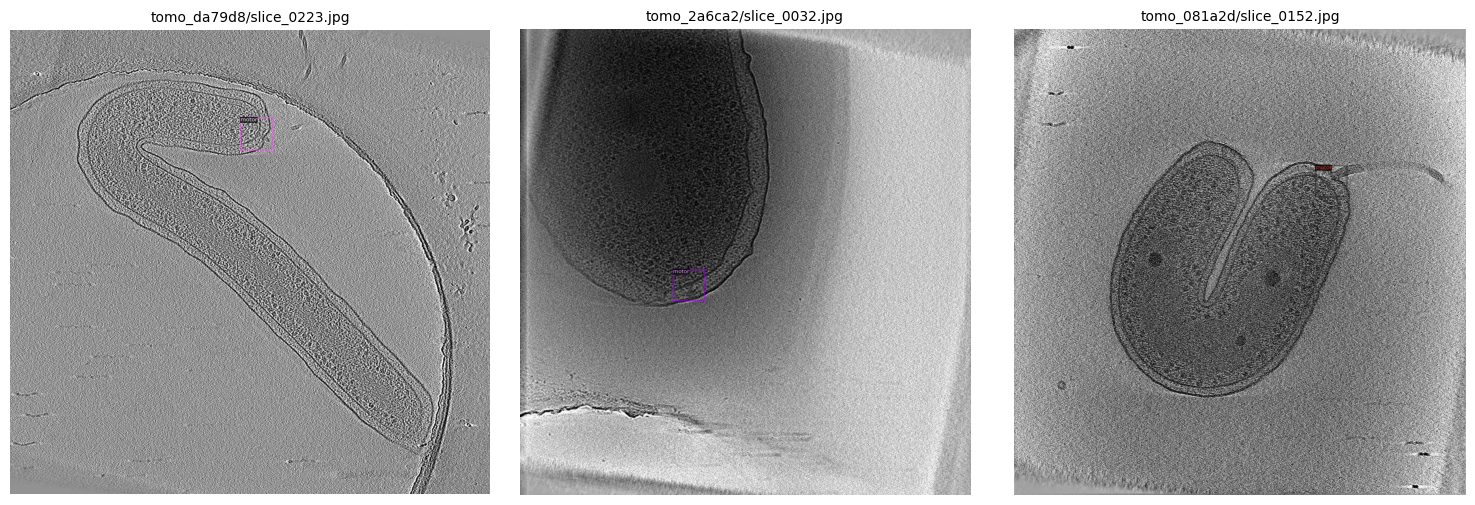

In [10]:
plt.figure(figsize=(15, 5))

samples = random.sample(train_dataset, 3)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    visualizer = Visualizer(img, metadata=train_metadata, scale=1.0)
    vis = visualizer.draw_dataset_dict(sample)

    plt.subplot(1, 3, i + 1)
    plt.imshow(vis.get_image())
    plt.title("/".join(sample["file_name"].split("/")[-2:]), fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Training configs

In [11]:
def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(CFG.model_name))

    cfg.DATASETS.TRAIN = ("train",)
    cfg.DATASETS.TEST = ("val",)
    
    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.SOLVER.IMS_PER_BATCH = CFG.batch_size
    cfg.SOLVER.BASE_LR = CFG.learning_rate
    cfg.SOLVER.MAX_ITER = CFG.max_iter
    cfg.SOLVER.STEPS = [2000, 4000, 6000]
    cfg.SOLVER.GAMMA = 0.1
    cfg.SOLVER.WARMUP_ITERS = CFG.warmup_iters
    cfg.SOLVER.CHECKPOINT_PERIOD = CFG.checkpoint_period
    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = CFG.threshold
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CFG.model_name)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

    cfg.TEST.EVAL_PERIOD = CFG.eval_period
    cfg.TEST.AUG.ENABLED = True

    cfg.OUTPUT_DIR = CFG.output_dir

    return cfg

In [12]:
cfg = setup_cfg()

# Training

In [13]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "evaluation")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    
    def build_hooks(self):
        hooks_list = super().build_hooks()
        
        for idx, hook in enumerate(hooks_list):
            if isinstance(hook, hooks.PeriodicCheckpointer):
                hooks_list.pop(idx)
                break
        
        hooks_list.append(
            hooks.BestCheckpointer(
                eval_period=self.cfg.TEST.EVAL_PERIOD,
                checkpointer=DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR),
                val_metric="bbox/AP",
                mode="max",
                file_prefix="best_checkpoint"
            )
        )
        return hooks_list

In [14]:
trainer = Trainer(cfg)

[05/01 19:40:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/518 [00:00<?, ?it/s]

[05/01 19:40:37 d2.data.build]: Removed 0 images with no usable annotations. 372 images left.
[05/01 19:40:37 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   motor    | 372          |
|            |              |
[05/01 19:40:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/01 19:40:37 d2.data.build]: Using training sampler TrainingSampler
[05/01 19:40:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/01 19:40:37 d2.data.common]: Serializing 372 elements to byte tensors and concatenating them all ...
[05/01 19:40:37 d2.data.common]: Serialized dataset takes 0.15 MiB
[05/01 19:40:37 d2.data.build]: Making batched data loader with batch_size=8


In [15]:
trainer.resume_or_load(resume=False)
trainer.train()

[05/01 19:40:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl ...


model_final_68b088.pkl: 421MB [00:02, 193MB/s]                           


[05/01 19:40:39 d2.engine.train_loop]: Starting training from iteration 0
[05/01 19:42:38 d2.utils.events]:  eta: 10:37:12  iter: 19  total_loss: 0.7439  loss_cls: 0.4372  loss_box_reg: 0.0005254  loss_rpn_cls: 0.2922  loss_rpn_loc: 0.0183    time: 5.7804  last_time: 5.9125  data_time: 0.1403  last_data_time: 0.1858   lr: 1.9981e-05  max_mem: 13350M
[05/01 19:44:46 d2.utils.events]:  eta: 10:33:46  iter: 39  total_loss: 0.5194  loss_cls: 0.2468  loss_box_reg: 0.0003906  loss_rpn_cls: 0.2441  loss_rpn_loc: 0.01435    time: 5.7995  last_time: 6.0143  data_time: 0.1273  last_data_time: 0.1586   lr: 3.9961e-05  max_mem: 13350M
[05/01 19:46:42 d2.utils.events]:  eta: 10:32:34  iter: 59  total_loss: 0.3815  loss_cls: 0.1434  loss_box_reg: 0.02917  loss_rpn_cls: 0.18  loss_rpn_loc: 0.01286    time: 5.7967  last_time: 5.9626  data_time: 0.1105  last_data_time: 0.1483   lr: 5.9941e-05  max_mem: 13350M
[05/01 19:48:37 d2.utils.events]:  eta: 10:30:36  iter: 79  total_loss: 0.4058  loss_cls: 0.18

  0%|          | 0/130 [00:00<?, ?it/s]

[05/01 20:29:14 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   motor    | 79           |
|            |              |
[05/01 20:29:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/01 20:29:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/01 20:29:14 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/01 20:29:14 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/01 20:29:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/01 20:29:14 d2.evaluation.coco_evaluation]: Trying to convert 'val' to COCO format ...
[05/01 20:29:15 d2.data.datasets.coco]: Converting annotations of dat

  0%|          | 0/130 [00:00<?, ?it/s]

[05/01 20:29:15 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/01 20:29:15 d2.data.datasets.coco]: Conversion finished, #images: 79, #annotations: 79
[05/01 20:29:15 d2.data.datasets.coco]: Caching COCO format annotations at 'faster_rcnn_X_101_32x8d_FPN_3x_fold_0/evaluation/val_coco_format.json' ...
[05/01 20:29:15 d2.evaluation.evaluator]: Start inference on 79 batches
[05/01 20:29:17 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0016 s/iter. Inference: 0.1221 s/iter. Eval: 0.0002 s/iter. Total: 0.1239 s/iter. ETA=0:00:08
[05/01 20:29:22 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0019 s/iter. Inference: 0.1224 s/iter. Eval: 0.0002 s/iter. Total: 0.1246 s/iter. ETA=0:00:03
[05/01 20:29:25 d2.evaluation.evaluator]: Total inference time: 0:00:09.277418 (0.125371 s / iter per device, on 1 devices)
[05/01 20:29:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:09 (0.122559 s / iter per device, on 1 devices)
[05/

  0%|          | 0/130 [00:00<?, ?it/s]

[05/01 21:17:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/01 21:17:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/01 21:17:40 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/01 21:17:40 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/01 21:17:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/01 21:17:40 d2.evaluation.evaluator]: Start inference on 79 batches
[05/01 21:17:41 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0015 s/iter. Inference: 0.1225 s/iter. Eval: 0.0003 s/iter. Total: 0.1243 s/iter. ETA=0:00:08
[05/01 21:17:46 d2.evaluation.evaluator]: Inference done 51/79. Dataloading: 0.0019 s/iter. Inference: 0.1227 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/01 22:06:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/01 22:06:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/01 22:06:01 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/01 22:06:01 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/01 22:06:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/01 22:06:01 d2.evaluation.evaluator]: Start inference on 79 batches
[05/01 22:06:02 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0015 s/iter. Inference: 0.1250 s/iter. Eval: 0.0003 s/iter. Total: 0.1268 s/iter. ETA=0:00:08
[05/01 22:06:07 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0019 s/iter. Inference: 0.1229 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/01 22:54:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/01 22:54:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/01 22:54:12 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/01 22:54:12 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/01 22:54:12 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/01 22:54:12 d2.evaluation.evaluator]: Start inference on 79 batches
[05/01 22:54:14 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0015 s/iter. Inference: 0.1214 s/iter. Eval: 0.0002 s/iter. Total: 0.1231 s/iter. ETA=0:00:08
[05/01 22:54:19 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0019 s/iter. Inference: 0.1218 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/01 23:42:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/01 23:42:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/01 23:42:18 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/01 23:42:18 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/01 23:42:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/01 23:42:18 d2.evaluation.evaluator]: Start inference on 79 batches
[05/01 23:42:19 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0015 s/iter. Inference: 0.1219 s/iter. Eval: 0.0002 s/iter. Total: 0.1236 s/iter. ETA=0:00:08
[05/01 23:42:25 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0018 s/iter. Inference: 0.1220 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/02 00:30:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/02 00:30:31 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 00:30:31 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/02 00:30:31 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/02 00:30:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/02 00:30:31 d2.evaluation.evaluator]: Start inference on 79 batches
[05/02 00:30:32 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0015 s/iter. Inference: 0.1223 s/iter. Eval: 0.0002 s/iter. Total: 0.1241 s/iter. ETA=0:00:08
[05/02 00:30:37 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0018 s/iter. Inference: 0.1218 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/02 01:18:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/02 01:18:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 01:18:48 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/02 01:18:48 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/02 01:18:48 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/02 01:18:48 d2.evaluation.evaluator]: Start inference on 79 batches
[05/02 01:18:50 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0014 s/iter. Inference: 0.1216 s/iter. Eval: 0.0002 s/iter. Total: 0.1233 s/iter. ETA=0:00:08
[05/02 01:18:55 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0018 s/iter. Inference: 0.1220 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/02 02:07:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/02 02:07:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 02:07:12 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/02 02:07:12 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/02 02:07:12 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/02 02:07:12 d2.evaluation.evaluator]: Start inference on 79 batches
[05/02 02:07:14 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0016 s/iter. Inference: 0.1212 s/iter. Eval: 0.0002 s/iter. Total: 0.1230 s/iter. ETA=0:00:08
[05/02 02:07:19 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0018 s/iter. Inference: 0.1216 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/02 02:55:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/02 02:55:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 02:55:32 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/02 02:55:32 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/02 02:55:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/02 02:55:32 d2.evaluation.evaluator]: Start inference on 79 batches
[05/02 02:55:34 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0015 s/iter. Inference: 0.1218 s/iter. Eval: 0.0002 s/iter. Total: 0.1235 s/iter. ETA=0:00:08
[05/02 02:55:39 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0019 s/iter. Inference: 0.1221 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/02 03:43:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/02 03:43:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 03:43:43 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/02 03:43:43 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/02 03:43:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/02 03:43:43 d2.evaluation.evaluator]: Start inference on 79 batches
[05/02 03:43:44 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0016 s/iter. Inference: 0.1216 s/iter. Eval: 0.0002 s/iter. Total: 0.1234 s/iter. ETA=0:00:08
[05/02 03:43:49 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0018 s/iter. Inference: 0.1219 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/02 04:31:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/02 04:31:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 04:31:55 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/02 04:31:55 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/02 04:31:55 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/02 04:31:55 d2.evaluation.evaluator]: Start inference on 79 batches
[05/02 04:31:57 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0015 s/iter. Inference: 0.1216 s/iter. Eval: 0.0002 s/iter. Total: 0.1233 s/iter. ETA=0:00:08
[05/02 04:32:02 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0018 s/iter. Inference: 0.1216 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/02 05:20:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/02 05:20:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 05:20:17 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/02 05:20:17 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/02 05:20:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/02 05:20:17 d2.evaluation.evaluator]: Start inference on 79 batches
[05/02 05:20:19 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0013 s/iter. Inference: 0.1211 s/iter. Eval: 0.0002 s/iter. Total: 0.1226 s/iter. ETA=0:00:08
[05/02 05:20:24 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0016 s/iter. Inference: 0.1212 s/iter.

  0%|          | 0/130 [00:00<?, ?it/s]

[05/02 06:08:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/02 06:08:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 06:08:43 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/02 06:08:43 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [05/02 06:08:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/02 06:08:43 d2.evaluation.evaluator]: Start inference on 79 batches
[05/02 06:08:44 d2.evaluation.evaluator]: Inference done 11/79. Dataloading: 0.0014 s/iter. Inference: 0.1211 s/iter. Eval: 0.0002 s/iter. Total: 0.1228 s/iter. ETA=0:00:08
[05/02 06:08:49 d2.evaluation.evaluator]: Inference done 52/79. Dataloading: 0.0016 s/iter. Inference: 0.1214 s/iter.

In [16]:
metrics = []
for line in open(f"{CFG.output_dir}/metrics.json"):
    metrics.append(json.loads(line))
    
metrics = pd.DataFrame(metrics)

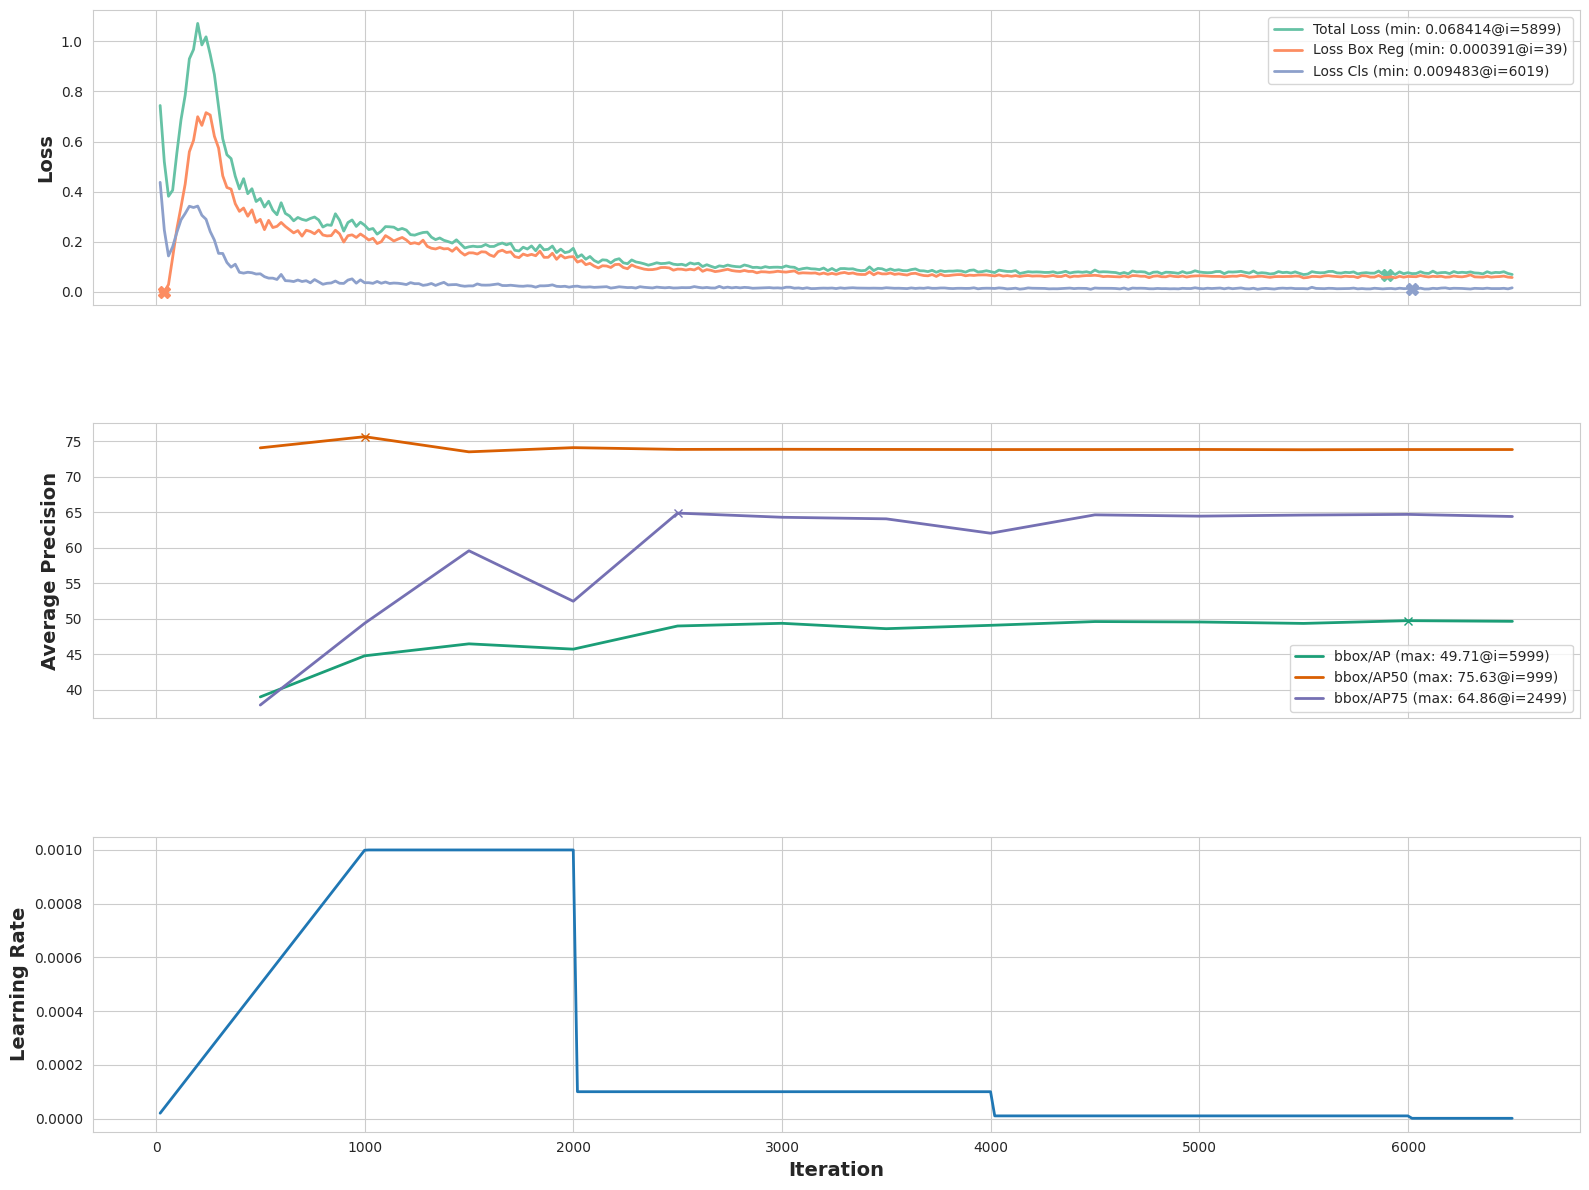

In [17]:
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

colors1 = sns.color_palette("Set2", n_colors=3)
for idx, col in enumerate(["total_loss", "loss_box_reg", "loss_cls"]):
    min_val = metrics[col].min()
    min_row = metrics.loc[metrics[col].idxmin()]
    label = f"{col.replace('_', ' ').title()} (min: {min_val:.6f}@i={int(min_row.iteration)})"
    sns.lineplot(x="iteration", y=col, ax=ax1, data=metrics, linewidth=2, label=label, color=colors1[idx])
    ax1.plot(min_row["iteration"], min_row[col], marker="X", markersize=8, color=colors1[idx])

ax1.set_ylabel("Loss", fontsize=14, weight='bold')
ax1.legend(loc="upper right", frameon=True)
ax1.grid(True)

colors2 = sns.color_palette("Dark2", n_colors=3)
for idx, col in enumerate(["bbox/AP", "bbox/AP50", "bbox/AP75"]):
    max_val = metrics[col].max()
    max_row = metrics.loc[metrics[col].idxmax()]
    label = f"{col} (max: {max_val:.2f}@i={int(max_row.iteration)})"
    sns.lineplot(x="iteration", y=col, ax=ax2, data=metrics, linewidth=2, label=label, color=colors2[idx])
    ax2.plot(max_row["iteration"], max_row[col], marker="x", markersize=6, color=colors2[idx])

ax2.set_ylabel("Average Precision", fontsize=14, weight='bold')
ax2.legend(loc="lower right", frameon=True)
ax2.grid(True)

sns.lineplot(x="iteration", y="lr", ax=ax3, linewidth=2, data=metrics, color="tab:blue")
ax3.set_ylabel("Learning Rate", fontsize=14, weight='bold')
ax3.grid(True)


plt.xlabel("Iteration", fontsize=14, weight='bold')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()
